#### Note: This notebook uses the Smooth class from the paper Certified Adversarial Robustness via Randomized Smoothing. The github for the project used can be found here: https://github.com/locuslab/smoothing/tree/master

### Imports

In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Check that cuda is being utilized (Required for Smooth)
print(device)

cuda


In [3]:
# Additional imports
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random
from tensorflow.image import resize
#import cv2
from itertools import islice
#from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
import copy
from tensorflow.keras import backend as K
import json, torch
import torch.nn as nn
from sklearn.preprocessing import LabelBinarizer
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Prepare Data

In [4]:
#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


In [5]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=(0.1325,), std=(0.3105,))
           )


### Get Data in compatible formats

In [6]:
x_test = []
y_test = []
x_train = []
y_train = []

for images, labels in test_loader:

    for i in range(len(labels)):

        x_test.append(images[i])
        y_test.append(labels[i])
        
for images, labels in train_loader:
    for i in range(len(labels)):
        x_train.append(images[i])
        y_train.append(labels[i])
    


In [7]:
print(len(x_test))
print(len(y_test))
print(len(x_train))
print(len(y_train))

print(x_test[0])
print(y_test[0])
print(x_train[0])
print(y_train[0])

10000
10000
60000
60000
tensor([[[-0.4267, -0.4267, -0.4267,  ..., -0.4267, -0.4267, -0.4267],
         [-0.4267, -0.4267, -0.4267,  ..., -0.4267, -0.4267, -0.4267],
         [-0.4267, -0.4267, -0.4267,  ..., -0.4267, -0.4267, -0.4267],
         ...,
         [-0.4267, -0.4267, -0.4267,  ..., -0.4267, -0.4267, -0.4267],
         [-0.4267, -0.4267, -0.4267,  ..., -0.4267, -0.4267, -0.4267],
         [-0.4267, -0.4267, -0.4267,  ..., -0.4267, -0.4267, -0.4267]]])
tensor(7)
tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]])
tensor(8)


### Define Lenet Model Class

Used the following source to build LeNet class: https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/

In [8]:
#Define LeNet Class
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        #super(ConvNeuralNet, self).__init__()
        super(LeNet5, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Linear(400, 120)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(120, 84)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(84, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.relu(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

### Build the Model

In [9]:
model = LeNet5(num_classes).to(device)

#Use Cross Entropy for loss
cost = nn.CrossEntropyLoss()

#Set Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Show steps
total_step = len(train_loader)

### Train the Model

In [10]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images.cuda())
        loss = cost(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.0352
Epoch [1/10], Step [800/938], Loss: 0.1065
Epoch [2/10], Step [400/938], Loss: 0.1665
Epoch [2/10], Step [800/938], Loss: 0.0148
Epoch [3/10], Step [400/938], Loss: 0.0095
Epoch [3/10], Step [800/938], Loss: 0.0356
Epoch [4/10], Step [400/938], Loss: 0.0144
Epoch [4/10], Step [800/938], Loss: 0.0071
Epoch [5/10], Step [400/938], Loss: 0.0032
Epoch [5/10], Step [800/938], Loss: 0.0480
Epoch [6/10], Step [400/938], Loss: 0.0263
Epoch [6/10], Step [800/938], Loss: 0.0048
Epoch [7/10], Step [400/938], Loss: 0.0521
Epoch [7/10], Step [800/938], Loss: 0.0011
Epoch [8/10], Step [400/938], Loss: 0.0060
Epoch [8/10], Step [800/938], Loss: 0.0012
Epoch [9/10], Step [400/938], Loss: 0.0106
Epoch [9/10], Step [800/938], Loss: 0.0008
Epoch [10/10], Step [400/938], Loss: 0.0023
Epoch [10/10], Step [800/938], Loss: 0.0112


### Test the model against Mnist Data

In [11]:
# Test the model
  
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy: {} %'.format(100 * correct / total))
	 

Accuracy: 99.11 %


### Smoothing

In [12]:
# Additional imports for smoothing
import core
from core import Smooth


### Create Smoothed Classifier from Base Classifier

In [26]:
smoothed_lenet = Smooth(model, num_classes=10, sigma=0.25)
print(smoothed_lenet)

### Test Smoothed Model

In [14]:
#print(x_test[0])

x_test_torch = torch.stack(x_test)
total = 0
correct = 0
print(len(y_test) == len(x_test_torch))
print(len(y_test))
for i in range(len(x_test_torch)):
    result = smoothed_lenet.predict(x_test_torch[i].to(device), n=10, alpha=0.5, batch_size=64)
    if result == y_test[i]:
        correct += 1
    total += 1
print(correct / total)

True
10000
0.9848


In [15]:
import pickle


#### Misc Function

In [16]:
## Function for showing images
# Reference: https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

def show_images(images, title_texts):
    '''Function to show set of grayscale images with titles'''
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

### Load in Adversarial Images

In [17]:
adv_data = []
with (open("../../LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_images/lenet_test_adv_images.pickle", "rb")) as openfile:
    while True:
        try:
            adv_data.append(pickle.load(openfile))
        except EOFError:
            break


In [18]:
adv_labels = []
with (open("../../LeNet_Adversarial_Data/adv_mnist_xtest/Adversarial_test_image_labels/lenet_test_adv_labels.pickle", "rb")) as openfile:
    while True:
        try:
            adv_labels.append(pickle.load(openfile))
        except EOFError:
            break


In [19]:
orig_labels = []
with (open("../../LeNet_Adversarial_Data/adv_mnist_xtest/Original_test_pred_labels/lenet_test_orig_labels.pickle", "rb")) as openfile:
    while True:
        try:
            orig_labels.append(pickle.load(openfile))
        except EOFError:
            break

[3, 3, 2, 6, 9]
[7, 2, 1, 0, 4]


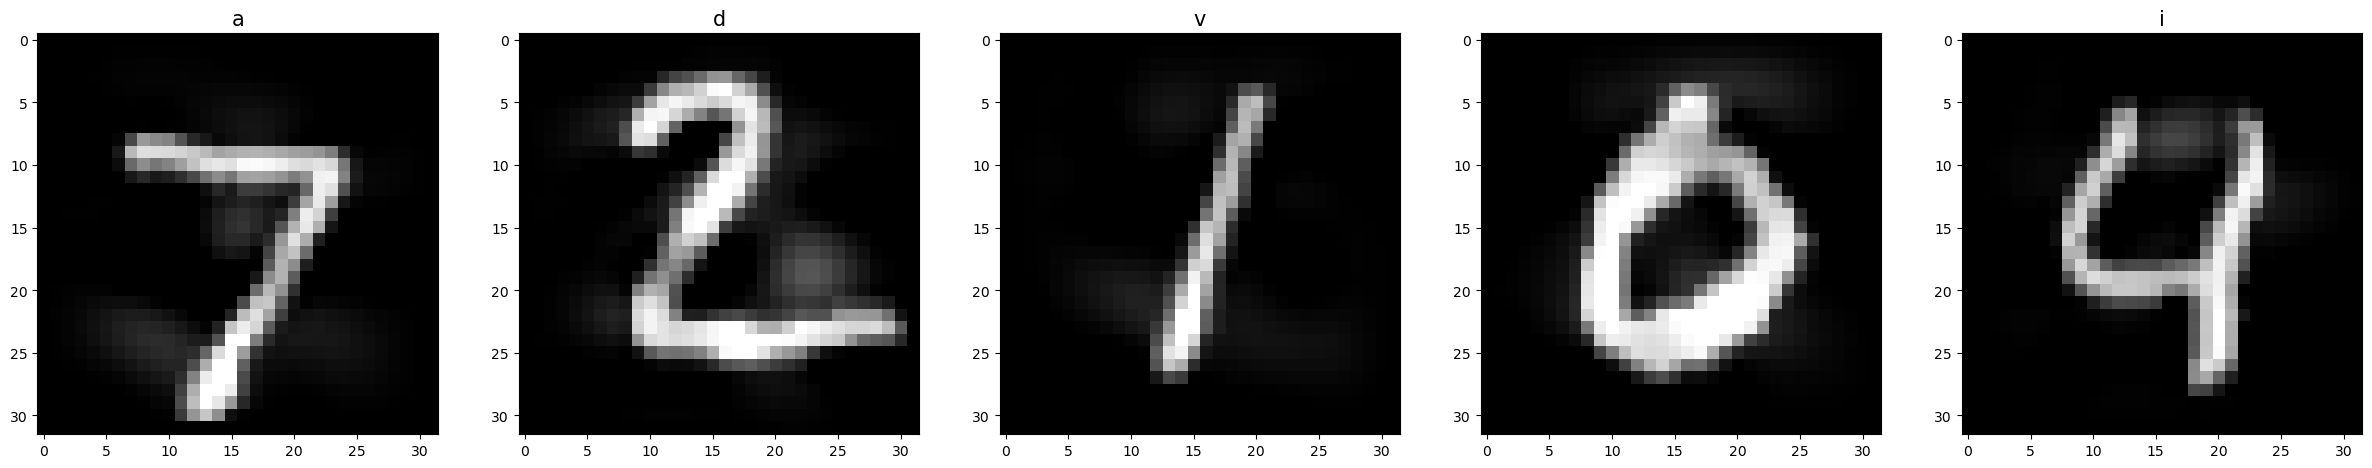

In [20]:
#print(len(adv_data[0]))
show_images(adv_data[0][:5], "adv images")
#show_images(x_test[:5], "truth images")
print((adv_labels[0][:5]))
print((orig_labels[0][:5]))

### Use Smoothed Classifier to Predict Adversarial Images

In [27]:
x_test_adv = [torch.tensor(im) for im in adv_data[0]]
x_test_adv = torch.stack(x_test_adv)
x_test_adv = np.transpose(x_test_adv, (0, 3, 1, 2))
total = 0
correct = 0
print(len(orig_labels[0]) == len(x_test_adv))
print(len(orig_labels[0]))
print(x_test_adv.shape)
for i in range(len(x_test_adv)):
    result = smoothed_lenet.predict(x_test_adv[i].to(device), n=10, alpha=0.5, batch_size=64)
    if result == orig_labels[0][i]:
        correct += 1
    total += 1
#print("Accuracy of Smoothed Model: " + str(correct / total))
print('Accuracy of Smoothed Classifier on Adversarial Images: {} %'.format(100 * correct / total))

True
10000
torch.Size([10000, 1, 32, 32])
Accuracy of Smoothed Classifier on Adversarial Images: 81.5 %


### Use original classifier to predict adversarial images

In [28]:
with torch.no_grad():
    correct = 0
    total = 0
    
    images = x_test_adv.to(device)
    labels = torch.tensor(orig_labels[0]).to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    print('Accuracy of Base Classifier on Adversarial Images: {} %'.format(100 * correct / total))
	 

Accuracy of Base Classifier on Adversarial Images: 47.73 %


In [29]:
for i in range(5):
    result = smoothed_lenet.predict(x_test_adv[i].to(device), n=10, alpha=0.8, batch_size=64)
    print(result)
print(predicted[0:5])

7
2
1
0
4
tensor([7, 1, 1, 0, 4], device='cuda:0')
